# cancer_text-better-drift

In [72]:
# copy from block 1 to 48

In [73]:
#read the data
import pandas as pd
df=pd.read_csv("data/cancerdoc/alldata_1_for_kaggle.csv",encoding='latin1')
df.head()

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7570 non-null   int64 
 1   0           7570 non-null   object
 2   a           7570 non-null   object
dtypes: int64(1), object(2)
memory usage: 177.5+ KB


In [75]:
#Check Duplicated vals
df.duplicated().sum()

0

In [76]:
#rename cols
df = df.rename(columns={'0': 'labels', 'a': 'text'})
df.head()

,Unnamed: 0,labels,text
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [77]:
# df['labels'].unique()
df['labels'].value_counts()

labels
Thyroid_Cancer    2810
Colon_Cancer      2580
Lung_Cancer       2180
Name: count, dtype: int64

#### add entropy

In [78]:
import pandas as pd
import numpy as np
from collections import Counter

def calculate_entropy(text):
    # Tokenize the text into characters
    tokens = list(text)
    # Count the frequency of each token
    token_counts = Counter(tokens)
    # Calculate probabilities
    total_count = sum(token_counts.values())
    probabilities = [count / total_count for count in token_counts.values()]
    # Compute entropy
    entropy = -sum(p * np.log2(p) for p in probabilities)
    return entropy

# Calculate entropy for each row in the text column
df['entropy'] = df['text'].apply(calculate_entropy)

df.head()

,Unnamed: 0,labels,text,entropy
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,4.477048
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",4.462335
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,4.678069
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,4.520333
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,4.544866


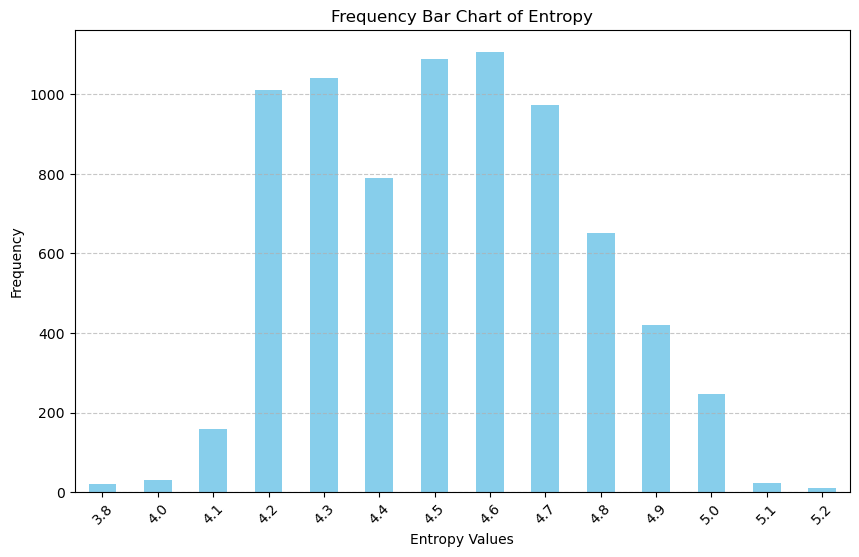

In [79]:
import matplotlib.pyplot as plt

df['entropy'] = df['entropy'].round(1)
# Plot the frequency bar chart
plt.figure(figsize=(10, 6))
df['entropy'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Frequency Bar Chart of Entropy')
plt.xlabel('Entropy Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [80]:
df.entropy.describe()

count    7570.000000
mean        4.517133
std         0.238839
min         3.800000
25%         4.300000
50%         4.500000
75%         4.700000
max         5.200000
Name: entropy, dtype: float64

In [81]:
texts = df['text'].values
labels = df['labels'].values

In [82]:
#split the data
from sklearn.model_selection import train_test_split

feature_cols = ['text', 'entropy']
X = df[feature_cols] # Features
y = df.labels # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True,stratify=labels)

print("Dimensions of X_train :", X_train.shape)
print("Dimensions of X_test  :", X_test.shape)
print("Dimensions of y_train :", y_train.shape)
print("Dimensions of y_test  :", y_test.shape)

Dimensions of X_train : (6056, 2)
Dimensions of X_test  : (1514, 2)
Dimensions of y_train : (6056,)
Dimensions of y_test  : (1514,)


In [83]:
# !pip install tensorflow

In [84]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])

X_train_seq = tokenizer.texts_to_sequences(X_train['text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['text'])
# X_train_seq[0]

In [85]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max([len(seq) for seq in X_train_seq])  # Maximum length of sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

X_train_pad[0]

array([    0,     0,     0, ...,     9, 70151,   165], dtype=int32)

In [86]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_ = label_encoder.fit_transform(y_train)
y_test_ = label_encoder.transform(y_test)



y_train_cat = to_categorical(y_train_, num_classes=3)
y_test_cat = to_categorical(y_test_, num_classes=3)

y_train_cat

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len))
model.add(SimpleRNN(128, return_sequences=False))
model.add(Dense(3, activation='softmax'))

In [88]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [89]:
history = model.fit(X_train_pad, y_train_cat, epochs=5, batch_size=32, validation_split=0.2)
history

Epoch 1/5
152/152 [==============================] - 215s 1s/step - loss: 0.9727 - accuracy: 0.6018 - val_loss: 0.7976 - val_accuracy: 0.7434
Epoch 2/5
152/152 [==============================] - 219s 1s/step - loss: 0.6646 - accuracy: 0.8524 - val_loss: 0.4973 - val_accuracy: 0.8597
Epoch 3/5
152/152 [==============================] - 219s 1s/step - loss: 0.2953 - accuracy: 0.9123 - val_loss: 0.2176 - val_accuracy: 0.9059
Epoch 4/5
152/152 [==============================] - 219s 1s/step - loss: 0.1545 - accuracy: 0.9379 - val_loss: 0.1581 - val_accuracy: 0.9323
Epoch 5/5
152/152 [==============================] - 219s 1s/step - loss: 0.1045 - accuracy: 0.9597 - val_loss: 0.1039 - val_accuracy: 0.9538


In [90]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)

print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

48/48 [==============================] - 6s 117ms/step - loss: 0.0866 - accuracy: 0.9670
Test loss: 0.08662749081850052
Test accuracy: 0.9669749140739441


In [91]:
import numpy as np
predictions = model.predict(X_test_pad)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

48/48 [==============================] - 6s 118ms/step


array([1, 1, 2, ..., 1, 2, 2])

In [92]:
res_df = pd.DataFrame({
    'Actual Labels': y_test_,
    'Predicted Labels': predicted_labels
})

res_df[:30]

,Actual Labels,Predicted Labels
0,1,1
1,1,1
2,2,2
3,0,0
4,1,1
5,2,2
6,2,2
7,0,0
8,2,2
9,1,1


In [93]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test_, predicted_labels, target_names=label_encoder.classes_))


                precision    recall  f1-score   support

  Colon_Cancer       0.98      0.93      0.95       516
   Lung_Cancer       1.00      0.99      1.00       436
Thyroid_Cancer       0.94      0.98      0.96       562

      accuracy                           0.97      1514
     macro avg       0.97      0.97      0.97      1514
  weighted avg       0.97      0.97      0.97      1514



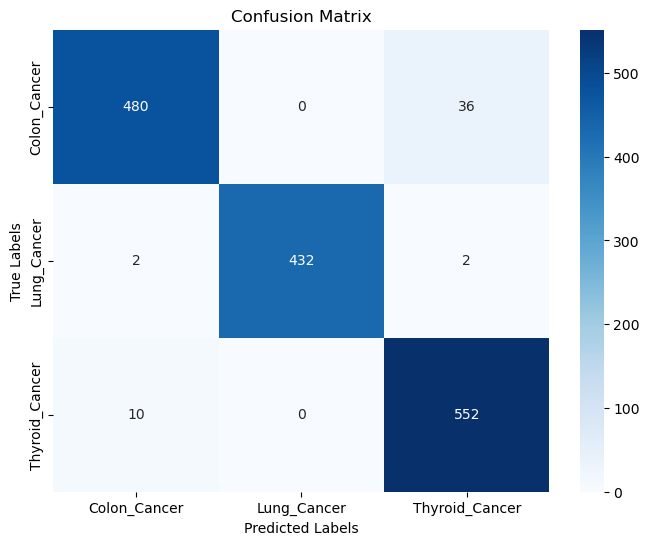

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test_, predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [95]:
type(model)

keras.src.engine.sequential.Sequential

In [97]:
# Save the model to a file
model.save('trained_cancer_text_model_new.keras')

import pickle
# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('trained_cancer_text_model.keras')      # For SavedModel format
# with open('tokenizer.pickle', 'rb') as handle:
#     loaded_tokenizer = pickle.load(handle)

In [98]:
res_df['entropy'] = X_test['entropy'].tolist()
res_df['text'] = X_test['text'].tolist()
res_df.head()

,Actual Labels,Predicted Labels,entropy,text
0,1,1,4.6,"""materials and marking with radio-opaque mater..."
1,1,1,4.5,"""Although de Torres et al. demonstrated by usi..."
2,2,2,4.6,range of diseases including malignancies and a...
3,0,0,4.2,""" inflammatory pseudotumour has been used to ..."
4,1,1,4.8,"""Former (quit ?1 y) 39 (48%) 30 (48%) 9 (50%) ..."


In [99]:
X_test['entropy'].unique()

array([4.6, 4.5, 4.2, 4.8, 4.7, 4.9, 4.3, 4.4, 5. , 4.1, 5.1, 3.8, 4. ])

In [100]:
test_df = res_df.copy()

In [101]:
test_df = test_df.rename(columns={'Actual Labels': 'true_label', 'Predicted Labels': 'y_pred_drifted'})
test_df.head()

,true_label,y_pred_drifted,entropy,text
0,1,1,4.6,"""materials and marking with radio-opaque mater..."
1,1,1,4.5,"""Although de Torres et al. demonstrated by usi..."
2,2,2,4.6,range of diseases including malignancies and a...
3,0,0,4.2,""" inflammatory pseudotumour has been used to ..."
4,1,1,4.8,"""Former (quit ?1 y) 39 (48%) 30 (48%) 9 (50%) ..."


# graphs 

In [102]:
from psi import calculate_psi

In [103]:
import numpy as np
import pandas as pd
num_iterations = 200

def get_simulation_input(X_test, X_test_drift, y_pred, y_pred_drift, sample_size = 50):
    # Store results for each iteration
    X_results = []
    y_results = []

    df_X = pd.DataFrame(columns=X_test.columns)
    arr_y = np.array([])

    for i in range(1, num_iterations + 1):
        if i <= 100:
            # First 100 iterations: Choose from X_test and y_pred
            random_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
            X_sample = X_test.iloc[random_indices]
            y_sample = y_pred[random_indices]
            # print(type(X_sample))
            # print(type(y_sample))
        elif 101 <= i <= 110:
            # Iterations 101-110: Choose from X_test_drift and y_pred_drift
            random_indices = np.random.choice(len(y_pred_drift), size=sample_size, replace=False)
            X_sample = X_test_drift.iloc[random_indices]
            y_sample = y_pred_drift[random_indices]
        else:
            # Iterations 111-200: Choose from X_test and y_pred
            random_indices = np.random.choice(len(y_pred), size=sample_size, replace=False)
            X_sample = X_test.iloc[random_indices]
            y_sample = y_pred[random_indices]

        df_X = pd.concat([df_X, X_sample], ignore_index=True)
        arr_y = np.append(arr_y, y_sample)
    return df_X, arr_y

In [104]:
from psi import calculate_psi


def get_psi_for_simulation_data(arr_y, window_size = 300):
    psi_values = []
    results = arr_y
    # Check if results array has enough data
    if len(results) < window_size:
        print("Not enough data in results for sliding window.")
    else:
        # Sliding window loop
        for start in range(len(results) - window_size + 1):
            # Get the current window
            window = results[start:start + window_size]
        
            # Extract expected and actual values
            expected = window[:window_size // 2]  # First half of the window
            actual = window[window_size // 2:]   # Second half of the window
        
            # Debugging: Check sizes
            # print(f"Processing window starting at index {start}")
            # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
            # Calculate PSI for the current window
            psi_value = calculate_psi(expected, actual, buckets=3, axis=0)  # edit
            psi_values.append(psi_value)
    return psi_values

In [105]:
import matplotlib.pyplot as plt

def plot_psi(psi_values, title):
    # Assuming psi_values is already calculated
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(psi_values)), psi_values, marker='o', linestyle='-', color='b', label='PSI Value')
    # plt.title('PSI Values Over Sliding Windows for classification result (y): model drift by data drift', fontsize=16)
    plt.title(title, fontsize=16)
    plt.xlabel('Sliding Window Index', fontsize=14)
    plt.ylabel('PSI Value', fontsize=14)
    plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold (0.1)')
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Better drift

<!-- ### 3 txt normal_output, data_drift, data_quality
redistribute
combine normal and drift in a df
recalculate entropy w integer
select normal and drift 
check psi 


from y of X data - find label 0, 1, 2 % distr
choose data that give y label % that have significant model and data drift psi


# data quality
reuse the X from drift
corrupt
load model
repredict
check psi, corrupt (factor) more as needed -->

In [ ]:
# consider 10*entropy

In [9]:
# test_df_orig = pd.read_csv("normal_output.csv")
# test_df_drift = pd.read_csv("data_drift_output.csv")
# # concatenate 
# # draw distr of the y_pred
# # sample the distr

In [10]:
# test_df_orig.head()

,Unnamed: 0,true_label,y_pred_drifted,entropy,text
0,0,2,2,4.6,pathogenesis of multiple myeloma MM is not com...
1,1,2,2,4.6,Exercise influences the impact ofpolychlorina...
2,2,1,1,4.6,"""Hypertension and renal insufficiency are two ..."
3,3,2,2,4.6,"""assess the antioxidative activity of selenium..."
4,4,1,1,4.6,"""n methylene blue (0.6 vs 1.0 cm P<0.001). MLM..."


In [11]:
# test_df_drift.head()

,Unnamed: 0,true_label,y_pred_drifted,entropy,text
0,0,1,1,4.6,"""materials and marking with radio-opaque mater..."
1,1,2,2,4.6,range of diseases including malignancies and a...
2,2,1,1,4.6,"""Biochemistry Biomarkers Medicine and Health S..."
3,3,2,2,4.6,progression of breast cancerare greatly affect...
4,4,2,2,4.6,Creative Commons Attribution License whichperm...


In [19]:
# test_df = pd.concat([test_df_orig, test_df_drift], axis=0, ignore_index=True)

## continue

In [106]:
test_df['entropy_default'] = test_df['entropy'].copy()  # backup 
test_df['entropy'] = test_df['entropy'] * 10  # Multiply entropy by 10

In [107]:
test_df.head()

,true_label,y_pred_drifted,entropy,text,entropy_default
0,1,1,46.0,"""materials and marking with radio-opaque mater...",4.6
1,1,1,45.0,"""Although de Torres et al. demonstrated by usi...",4.5
2,2,2,46.0,range of diseases including malignancies and a...,4.6
3,0,0,42.0,""" inflammatory pseudotumour has been used to ...",4.2
4,1,1,48.0,"""Former (quit ?1 y) 39 (48%) 30 (48%) 9 (50%) ...",4.8


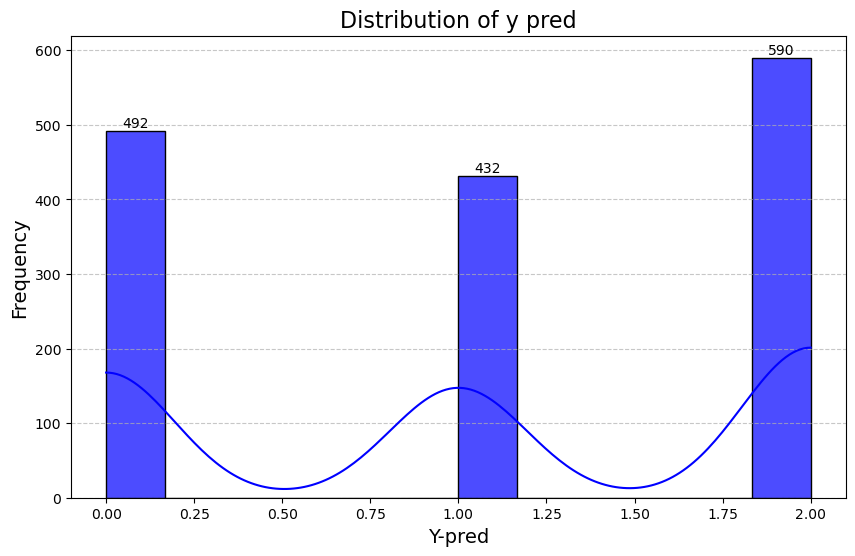

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of y pred
plt.figure(figsize=(10, 6))
ax = sns.histplot(test_df['y_pred_drifted'], kde=True, color='blue', alpha=0.7)

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of y pred', fontsize=16)
plt.xlabel('Y-pred', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

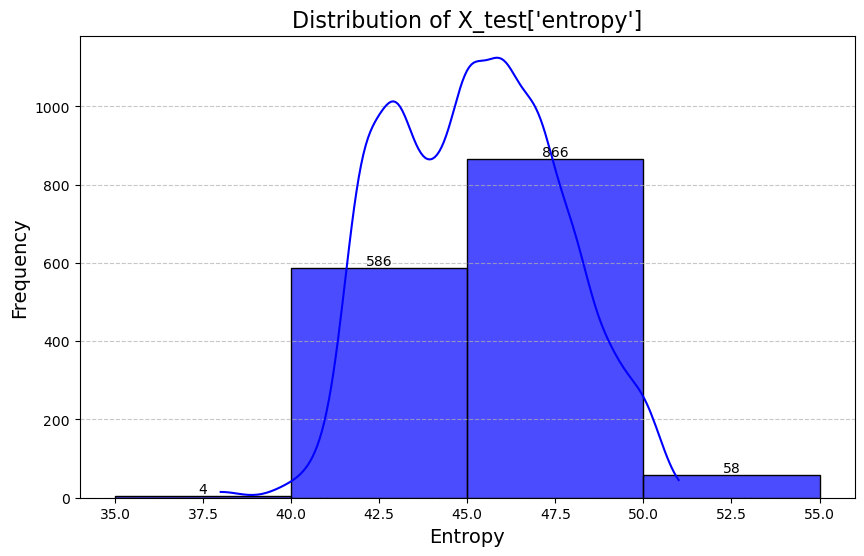

In [109]:
# Plot the distribution of 'entropy'
plt.figure(figsize=(10, 6))
ax = sns.histplot(test_df['entropy'], kde=True, color='blue', alpha=0.7, bins=[35, 40, 45, 50, 55], binrange=(30, 55))

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of X_test[\'entropy\']', fontsize=16)
plt.xlabel('Entropy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [110]:
# First filter by entropy to exclude 45-50 range from filtered samples
eligible_indices = test_df[
    (test_df['entropy'] < 45) | (test_df['entropy'] >= 50)
].index

# Get indices for each class from eligible rows only
class_0_indices = test_df[
    (test_df.index.isin(eligible_indices)) & 
    (test_df['y_pred_drifted'] == 0)
].index
class_1_indices = test_df[
    (test_df.index.isin(eligible_indices)) & 
    (test_df['y_pred_drifted'] == 1)
].index
class_2_indices = test_df[
    (test_df.index.isin(eligible_indices)) & 
    (test_df['y_pred_drifted'] == 2)
].index

# Create filtered_samples (193) with mostly class 0, excluding entropy 45-50
filtered_indices = np.concatenate([
    np.random.choice(class_0_indices, size=150, replace=False),  # Majority class 0
    np.random.choice(class_1_indices, size=23, replace=False),   # Few class 1
    np.random.choice(class_2_indices, size=20, replace=False)    # Few class 2
])

# Create filtered samples DataFrame
filtered_samples = test_df.loc[filtered_indices].copy().reset_index(drop=True)

# Get remaining samples as complement
remaining_samples = test_df.loc[~test_df.index.isin(filtered_indices)].copy().reset_index(drop=True)

In [111]:
filtered_samples.head()

,true_label,y_pred_drifted,entropy,text,entropy_default
0,0,0,44.0,s studies were published in a language othert...,4.4
1,0,0,40.0,previous studies have shown a strong coexiste...,4.0
2,0,0,43.0,""" colorectal cancer crc is the third leading c...",4.3
3,0,0,43.0,""" vibrio cholerae are oxidasepositive bacteri...",4.3
4,0,0,44.0,to the human gut microbiota biochem taxonomic...,4.4


In [139]:
print("Original y_pred distribution:\n", pd.Series(filtered_samples['y_pred_drifted']).value_counts(normalize=True))

Original y_pred distribution:
 y_pred_drifted
0    0.777202
1    0.119171
2    0.103627
Name: proportion, dtype: float64


In [140]:
print("Original entropy distribution:\n", pd.Series(filtered_samples['entropy']).value_counts(normalize=True))

Original entropy distribution:
 entropy
43.0    0.321244
42.0    0.284974
44.0    0.227979
50.0    0.103627
41.0    0.031088
40.0    0.020725
38.0    0.005181
51.0    0.005181
Name: proportion, dtype: float64


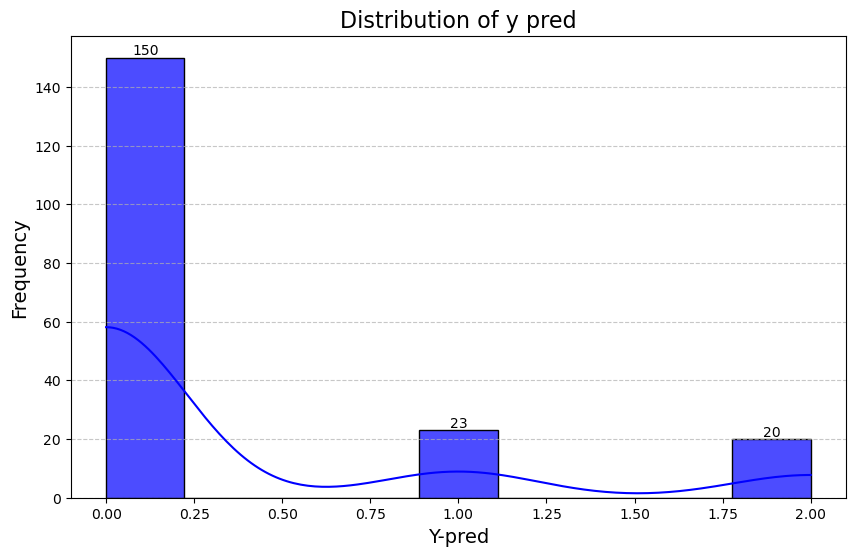

In [143]:
# Plot the distribution of y pred
plt.figure(figsize=(10, 6))
ax = sns.histplot(filtered_samples['y_pred_drifted'], kde=True, color='blue', alpha=0.7)

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of y pred', fontsize=16)
plt.xlabel('Y-pred', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

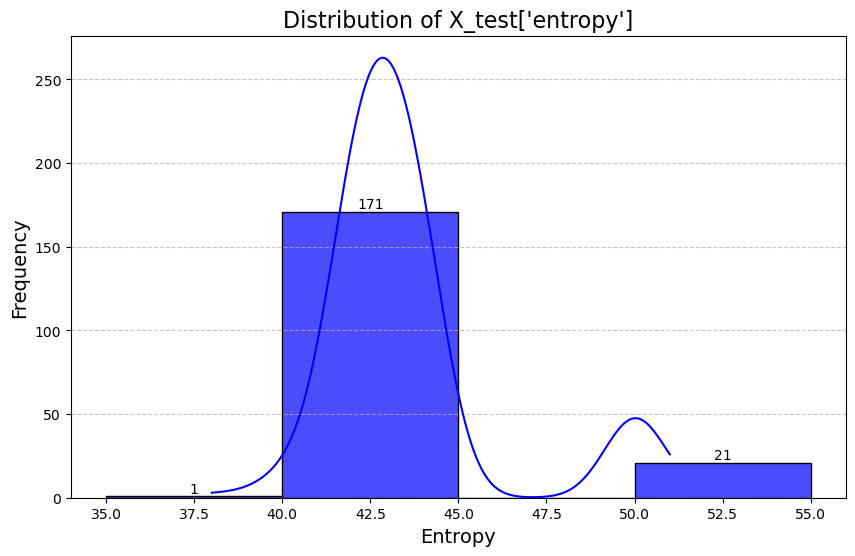

In [144]:
# Plot the distribution of 'entropy'
plt.figure(figsize=(10, 6))
ax = sns.histplot(filtered_samples['entropy'], kde=True, color='blue', alpha=0.7, bins=[35, 40, 45, 50, 55], binrange=(30, 55))

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of X_test[\'entropy\']', fontsize=16)
plt.xlabel('Entropy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [112]:
remaining_samples.head()

,true_label,y_pred_drifted,entropy,text,entropy_default
0,1,1,46.0,"""materials and marking with radio-opaque mater...",4.6
1,1,1,45.0,"""Although de Torres et al. demonstrated by usi...",4.5
2,2,2,46.0,range of diseases including malignancies and a...,4.6
3,1,1,48.0,"""Former (quit ?1 y) 39 (48%) 30 (48%) 9 (50%) ...",4.8
4,2,2,45.0,Rheumatoid arthritis RA is a systemic chronic...,4.5


In [113]:
calculate_psi(filtered_samples['y_pred_drifted'], remaining_samples['y_pred_drifted'], buckets=3, axis=1)

1.2192748563312343

In [114]:
calculate_psi(filtered_samples['entropy'], remaining_samples['entropy'], buckets=4, axis=1)

4.850747552855166

In [115]:
def get_psi_for_simulation_data(arr_y, window_size = 300):
    psi_values = []
    results = arr_y
    # Check if results array has enough data
    if len(results) < window_size:
        print("Not enough data in results for sliding window.")
    else:
        # Sliding window loop
        for start in range(len(results) - window_size + 1):
            # Get the current window
            window = results[start:start + window_size]
        
            # Extract expected and actual values
            expected = window[:window_size // 2]  # First half of the window
            actual = window[window_size // 2:]   # Second half of the window
        
            # Debugging: Check sizes
            # print(f"Processing window starting at index {start}")
            # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
            # Calculate PSI for the current window
            psi_value = calculate_psi(expected, actual, buckets=3, axis=0)  # edit
            psi_values.append(psi_value)
    return psi_values

/tmp/ipykernel_253049/3595005488.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_X = pd.concat([df_X, X_sample], ignore_index=True)


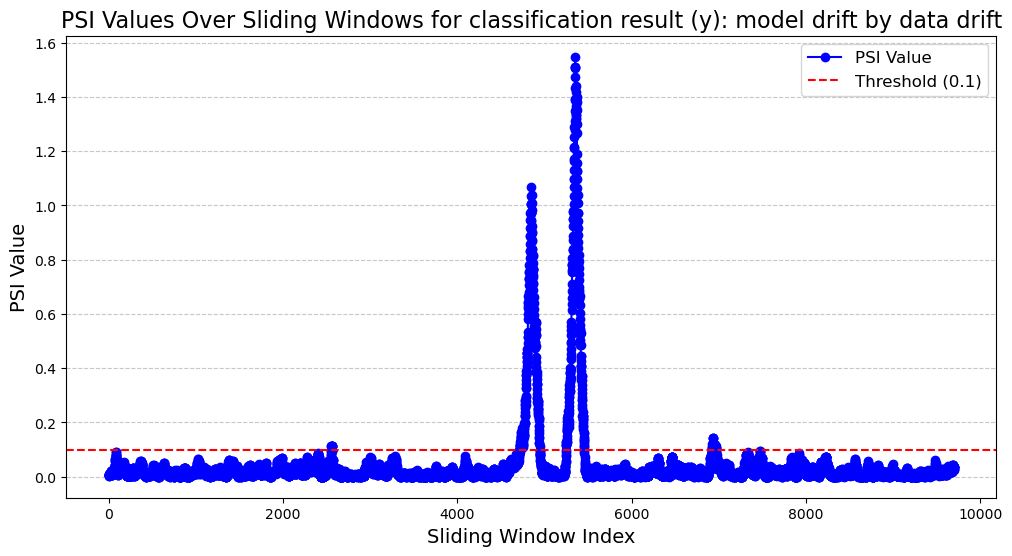

In [116]:
df_X, arr_y =  get_simulation_input(filtered_samples, remaining_samples, filtered_samples['y_pred_drifted'], remaining_samples['y_pred_drifted'], sample_size = 50)
psi_values = get_psi_for_simulation_data(arr_y, window_size = 300)
title='PSI Values Over Sliding Windows for classification result (y): model drift by data drift'
plot_psi(psi_values, title)

In [117]:
def get_psi_for_simulation_data(arr_y, window_size = 300):
    psi_values = []
    results = arr_y
    # Check if results array has enough data
    if len(results) < window_size:
        print("Not enough data in results for sliding window.")
    else:
        # Sliding window loop
        for start in range(len(results) - window_size + 1):
            # Get the current window
            window = results[start:start + window_size]
        
            # Extract expected and actual values
            expected = window[:window_size // 2]  # First half of the window
            actual = window[window_size // 2:]   # Second half of the window
        
            # Debugging: Check sizes
            # print(f"Processing window starting at index {start}")
            # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
            # Calculate PSI for the current window
            psi_value = calculate_psi(expected, actual, buckets=4, axis=0)  # edit
            psi_values.append(psi_value)
    return psi_values

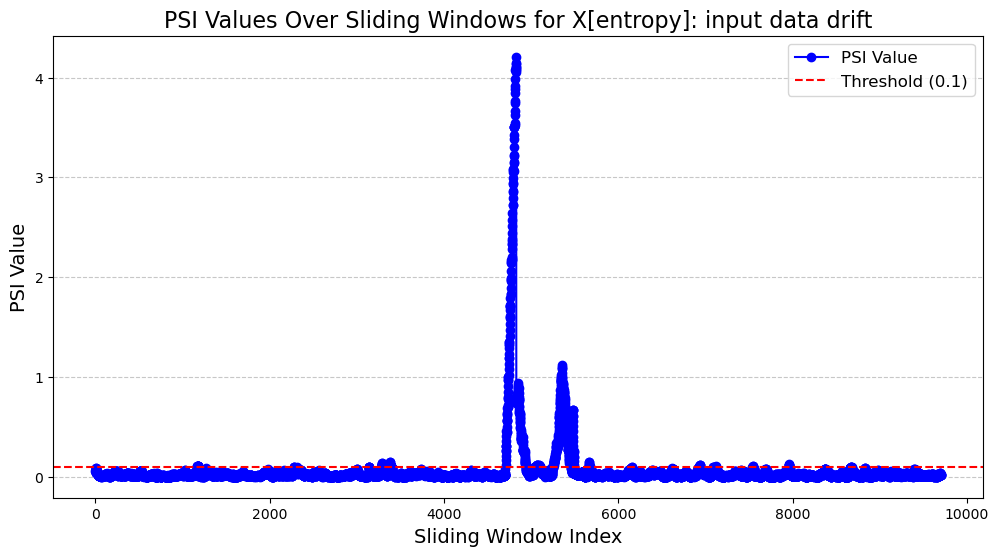

In [118]:
results = df_X['entropy']
psi_values = get_psi_for_simulation_data(results, window_size = 300)
title='PSI Values Over Sliding Windows for X[entropy]: input data drift'
plot_psi(psi_values, title)

In [119]:
test_results = filtered_samples.copy()
test_results.head()
test_results.to_csv("output/cancer-redo/normal_output.csv")

In [120]:
test_results = remaining_samples.copy()
test_results.head()
test_results.to_csv("output/cancer-redo/data_drift_output.csv")

In [121]:
import random 

In [122]:
# List of symbol characters
symbols = list("!@#$%^&*")

def corrupt_text_with_strings(text, symbols, corruption_rate=0.2, max_string_length=5):
    """
    Corrupts the text by randomly inserting strings of symbols.

    Parameters:
    - text: Original text string.
    - symbols: List of symbols to insert.
    - corruption_rate: Fraction of text length to corrupt.
    - max_string_length: Maximum length of the symbol string to insert.

    Returns:
    - Corrupted text string.
    """
    text_list = list(text)
    num_corruptions = max(1, int(len(text_list) * corruption_rate))

    for _ in range(num_corruptions):
        pos = random.randint(0, len(text_list))  # Random position
        symbol_string = ''.join(random.choices(symbols, k=random.randint(1, max_string_length)))  # Random string
        text_list.insert(pos, symbol_string)  # Insert symbol string

    return ''.join(text_list)

# Apply corruption to the 'text' column
remaining_samples['corrupted_text'] = remaining_samples['text'].apply(lambda x: corrupt_text_with_strings(x, symbols))

remaining_samples.head()

,true_label,y_pred_drifted,entropy,text,entropy_default,corrupted_text
0,1,1,46.0,"""materials and marking with radio-opaque mater...",4.6,"""materials a&!#!#&!$$$@@nd m&arking $***^with ..."
1,1,1,45.0,"""Although de Torres et al. demonstrated by usi...",4.5,"""Although de Torres et%$^ a$@%^#l. demonstr&%@..."
2,2,2,46.0,range of diseases including malignancies and a...,4.6,%!$range of di^!se!@@#a^ses incl&%uding *malig...
3,1,1,48.0,"""Former (quit ?1 y) 39 (48%) 30 (48%) 9 (50%) ...",4.8,"^$""Former (qui*&!@*%%t ?1 y#) 39 (48&%) 30 ^#$..."
4,2,2,45.0,Rheumatoid arthritis RA is a systemic chronic...,4.5,Rheumato$#id arthr%itis RA &%$&#is a s*!!y!*$...


In [123]:
import pandas as pd
import numpy as np
from collections import Counter

def calculate_entropy(text):
    # Tokenize the text into characters
    tokens = list(text)
    # Count the frequency of each token
    token_counts = Counter(tokens)
    # Calculate probabilities
    total_count = sum(token_counts.values())
    probabilities = [count / total_count for count in token_counts.values()]
    # Compute entropy
    entropy = -sum(p * np.log2(p) for p in probabilities)
    return entropy

In [124]:
remaining_samples['corrupted_entropy'] = remaining_samples['corrupted_text'].apply(calculate_entropy)
remaining_samples.head()

,true_label,y_pred_drifted,entropy,text,entropy_default,corrupted_text,corrupted_entropy
0,1,1,46.0,"""materials and marking with radio-opaque mater...",4.6,"""materials a&!#!#&!$$$@@nd m&arking $***^with ...",4.947719
1,1,1,45.0,"""Although de Torres et al. demonstrated by usi...",4.5,"""Although de Torres et%$^ a$@%^#l. demonstr&%@...",4.895822
2,2,2,46.0,range of diseases including malignancies and a...,4.6,%!$range of di^!se!@@#a^ses incl&%uding *malig...,4.950942
3,1,1,48.0,"""Former (quit ?1 y) 39 (48%) 30 (48%) 9 (50%) ...",4.8,"^$""Former (qui*&!@*%%t ?1 y#) 39 (48&%) 30 ^#$...",5.073463
4,2,2,45.0,Rheumatoid arthritis RA is a systemic chronic...,4.5,Rheumato$#id arthr%itis RA &%$&#is a s*!!y!*$...,4.884272


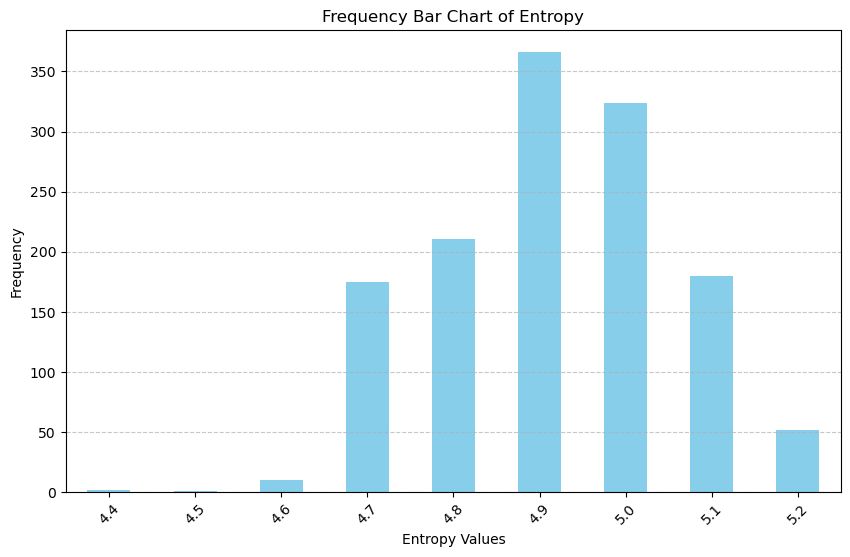

In [125]:
remaining_samples['corrupted_entropy'] = remaining_samples['corrupted_entropy'].round(1)
plt.figure(figsize=(10, 6))
remaining_samples['corrupted_entropy'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Frequency Bar Chart of Entropy')
plt.xlabel('Entropy Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [126]:
X_test_seq = tokenizer.texts_to_sequences(remaining_samples['corrupted_text'])
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
predictions = model.predict(X_test_pad)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

42/42 [==============================] - 5s 117ms/step


array([1, 0, 2, ..., 1, 1, 2])

In [127]:
remaining_samples['Corrupted Predicted Labels'] = predicted_labels
remaining_samples.head()

,true_label,y_pred_drifted,entropy,text,entropy_default,corrupted_text,corrupted_entropy,Corrupted Predicted Labels
0,1,1,46.0,"""materials and marking with radio-opaque mater...",4.6,"""materials a&!#!#&!$$$@@nd m&arking $***^with ...",4.9,1
1,1,1,45.0,"""Although de Torres et al. demonstrated by usi...",4.5,"""Although de Torres et%$^ a$@%^#l. demonstr&%@...",4.9,0
2,2,2,46.0,range of diseases including malignancies and a...,4.6,%!$range of di^!se!@@#a^ses incl&%uding *malig...,5.0,2
3,1,1,48.0,"""Former (quit ?1 y) 39 (48%) 30 (48%) 9 (50%) ...",4.8,"^$""Former (qui*&!@*%%t ?1 y#) 39 (48&%) 30 ^#$...",5.1,1
4,2,2,45.0,Rheumatoid arthritis RA is a systemic chronic...,4.5,Rheumato$#id arthr%itis RA &%$&#is a s*!!y!*$...,4.9,2


In [129]:
remaining_samples['corrupted_entropy_default'] = remaining_samples['corrupted_entropy'].copy()  # backup 
remaining_samples['corrupted_entropy'] = remaining_samples['corrupted_entropy'] * 10  # Multiply entropy by 10

In [130]:
remaining_samples.head()

,true_label,y_pred_drifted,entropy,text,entropy_default,corrupted_text,corrupted_entropy,Corrupted Predicted Labels,corrupted_entropy_default
0,1,1,46.0,"""materials and marking with radio-opaque mater...",4.6,"""materials a&!#!#&!$$$@@nd m&arking $***^with ...",49.0,1,4.9
1,1,1,45.0,"""Although de Torres et al. demonstrated by usi...",4.5,"""Although de Torres et%$^ a$@%^#l. demonstr&%@...",49.0,0,4.9
2,2,2,46.0,range of diseases including malignancies and a...,4.6,%!$range of di^!se!@@#a^ses incl&%uding *malig...,50.0,2,5.0
3,1,1,48.0,"""Former (quit ?1 y) 39 (48%) 30 (48%) 9 (50%) ...",4.8,"^$""Former (qui*&!@*%%t ?1 y#) 39 (48&%) 30 ^#$...",51.0,1,5.1
4,2,2,45.0,Rheumatoid arthritis RA is a systemic chronic...,4.5,Rheumato$#id arthr%itis RA &%$&#is a s*!!y!*$...,49.0,2,4.9


In [132]:
test_results = remaining_samples.copy()
# test_results = test_results[['Actual Labels', 'corrupted_text', 'corrupted_entropy', 'Corrupted Predicted Labels']]
test_results = test_results[['true_label', 'corrupted_text', 'corrupted_entropy', 'corrupted_entropy_default', 'Corrupted Predicted Labels']]
test_results = test_results.rename(columns={'Actual Labels': 'true_label', 'Corrupted Predicted Labels': 'y_pred_drifted', 'corrupted_text': 'text', 'corrupted_entropy': 'entropy', 'corrupted_entropy_default': 'entropy_default'})
test_results.head()

,true_label,text,entropy,entropy_default,y_pred_drifted
0,1,"""materials a&!#!#&!$$$@@nd m&arking $***^with ...",49.0,4.9,1
1,1,"""Although de Torres et%$^ a$@%^#l. demonstr&%@...",49.0,4.9,0
2,2,%!$range of di^!se!@@#a^ses incl&%uding *malig...,50.0,5.0,2
3,1,"^$""Former (qui*&!@*%%t ?1 y#) 39 (48&%) 30 ^#$...",51.0,5.1,1
4,2,Rheumato$#id arthr%itis RA &%$&#is a s*!!y!*$...,49.0,4.9,2


In [133]:
test_results.to_csv("output/cancer-redo/data_quality_output.csv")

In [134]:
calculate_psi(filtered_samples['y_pred_drifted'], remaining_samples['y_pred_drifted'], buckets=3, axis=1)

1.2192748563312343

In [137]:
def get_psi_for_simulation_data(arr_y, window_size = 300):
    psi_values = []
    results = arr_y
    # Check if results array has enough data
    if len(results) < window_size:
        print("Not enough data in results for sliding window.")
    else:
        # Sliding window loop
        for start in range(len(results) - window_size + 1):
            # Get the current window
            window = results[start:start + window_size]
        
            # Extract expected and actual values
            expected = window[:window_size // 2]  # First half of the window
            actual = window[window_size // 2:]   # Second half of the window
        
            # Debugging: Check sizes
            # print(f"Processing window starting at index {start}")
            # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
            # Calculate PSI for the current window
            psi_value = calculate_psi(expected, actual, buckets=3, axis=0)  # edit
            psi_values.append(psi_value)
    return psi_values

/tmp/ipykernel_253049/3595005488.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_X = pd.concat([df_X, X_sample], ignore_index=True)


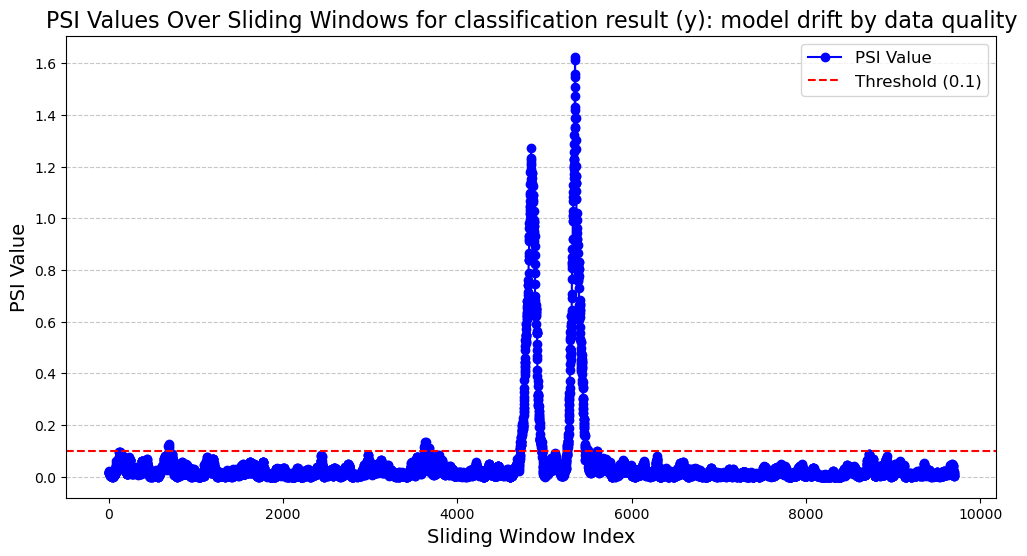

In [138]:
df_X, arr_y =  get_simulation_input(filtered_samples, remaining_samples, filtered_samples['y_pred_drifted'], remaining_samples['y_pred_drifted'], sample_size = 50)
psi_values = get_psi_for_simulation_data(arr_y, window_size = 300)
title='PSI Values Over Sliding Windows for classification result (y): model drift by data quality'
plot_psi(psi_values, title)

# trim text

In [181]:
import pandas as pd
import os

# Configuration
input_files = [
    "normal_output.csv",
    "data_drift_output.csv",
    "data_quality_output.csv"
]
output_dir = "/home/fogo/Documents/Code/DriftDemoScript/rnn-trim" # "data/rnn-trim"
trim_length = 15
trim_suffix = "...[trimmed]"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Function to process a DataFrame
def process_dataframe(df, trim_length, trim_suffix):
    if 'text' in df.columns:
        df = df.copy()
        df['text'] = df['text'].astype(str).apply(lambda x: x[:trim_length] + trim_suffix)
    return df


In [183]:
# Load and process each file
processed_dfs = {}
# input_dir = "/home/fogo/Documents/Code/DriftDemoScript/rnn"

for file in input_files:
    df = pd.read_csv(file)
    processed_df = process_dataframe(df, trim_length, trim_suffix)
    processed_dfs[file] = processed_df

In [184]:
processed_dfs["normal_output.csv"].head()

,Unnamed: 0,true_label,y_pred_drifted,entropy,text,entropy_default
0,0,0,0,44.0,s studies were...[trimmed],4.4
1,1,0,0,40.0,previous studi...[trimmed],4.0
2,2,0,0,43.0,""" colorectal ca...[trimmed]",4.3
3,3,0,0,43.0,""" vibrio chole...[trimmed]",4.3
4,4,0,0,44.0,to the human g...[trimmed],4.4


In [185]:
processed_dfs["data_drift_output.csv"].head()

,Unnamed: 0,true_label,y_pred_drifted,entropy,text,entropy_default
0,0,1,1,46.0,"""materials and ...[trimmed]",4.6
1,1,1,1,45.0,"""Although de To...[trimmed]",4.5
2,2,2,2,46.0,range of diseas...[trimmed],4.6
3,3,1,1,48.0,"""Former (quit ?...[trimmed]",4.8
4,4,2,2,45.0,Rheumatoid art...[trimmed],4.5


In [186]:
processed_dfs["data_quality_output.csv"].head()

,Unnamed: 0,true_label,text,entropy,entropy_default,y_pred_drifted
0,0,1,"""materials a&!#...[trimmed]",49.0,4.9,1
1,1,1,"""Although de To...[trimmed]",49.0,4.9,0
2,2,2,%!$range of di^...[trimmed],50.0,5.0,2
3,3,1,"^$""Former (qui*...[trimmed]",51.0,5.1,1
4,4,2,Rheumato$#id a...[trimmed],49.0,4.9,2


In [187]:
# To save the processed files after inspection:
def save_processed_dfs(dfs_dict, output_dir):
    for filename, df in dfs_dict.items():
        output_path = os.path.join(output_dir, filename)
        df.to_csv(output_path, index=False)
    print("All processed files saved to:", output_dir)

In [188]:
save_processed_dfs(processed_dfs, output_dir)

All processed files saved to: /home/fogo/Documents/Code/DriftDemoScript/rnn


In [189]:
calculate_psi(processed_dfs["normal_output.csv"]['y_pred_drifted'], processed_dfs["data_drift_output.csv"]['y_pred_drifted'], buckets=3, axis=1)

1.2192748563312343

/tmp/ipykernel_253049/3595005488.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_X = pd.concat([df_X, X_sample], ignore_index=True)


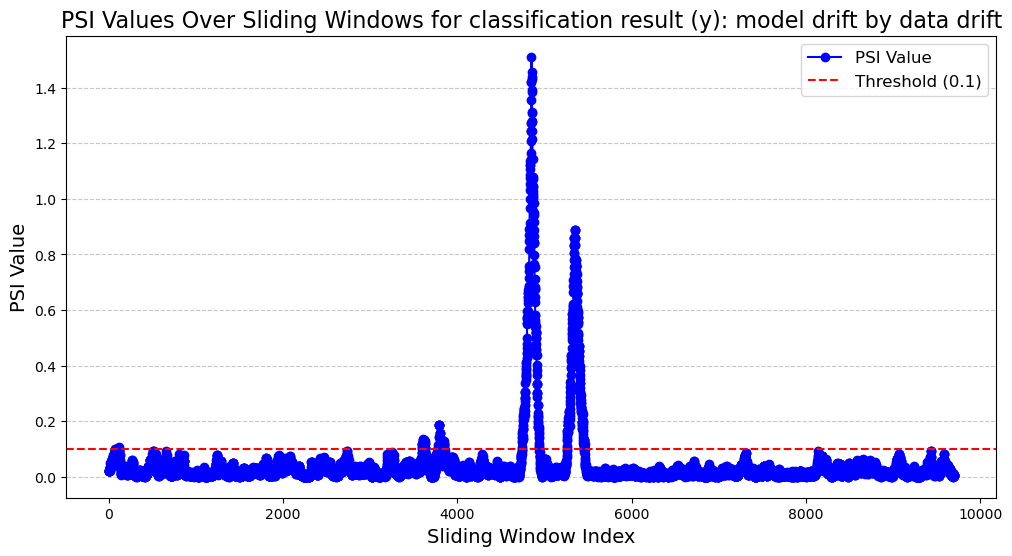

In [190]:
df_X, arr_y =  get_simulation_input(processed_dfs["normal_output.csv"], processed_dfs["data_drift_output.csv"], processed_dfs["normal_output.csv"]['y_pred_drifted'], processed_dfs["data_drift_output.csv"]['y_pred_drifted'], sample_size = 50)
psi_values = get_psi_for_simulation_data(arr_y, window_size = 300)
title='PSI Values Over Sliding Windows for classification result (y): model drift by data drift'
plot_psi(psi_values, title)

In [191]:
calculate_psi(processed_dfs["normal_output.csv"]['entropy'], processed_dfs["data_drift_output.csv"]['entropy'], buckets=4, axis=1)

4.850747552855166

In [192]:
def get_psi_for_simulation_data(arr_y, window_size = 300):
    psi_values = []
    results = arr_y
    # Check if results array has enough data
    if len(results) < window_size:
        print("Not enough data in results for sliding window.")
    else:
        # Sliding window loop
        for start in range(len(results) - window_size + 1):
            # Get the current window
            window = results[start:start + window_size]
        
            # Extract expected and actual values
            expected = window[:window_size // 2]  # First half of the window
            actual = window[window_size // 2:]   # Second half of the window
        
            # Debugging: Check sizes
            # print(f"Processing window starting at index {start}")
            # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
            # Calculate PSI for the current window
            psi_value = calculate_psi(expected, actual, buckets=4, axis=0)  # edit
            psi_values.append(psi_value)
    return psi_values

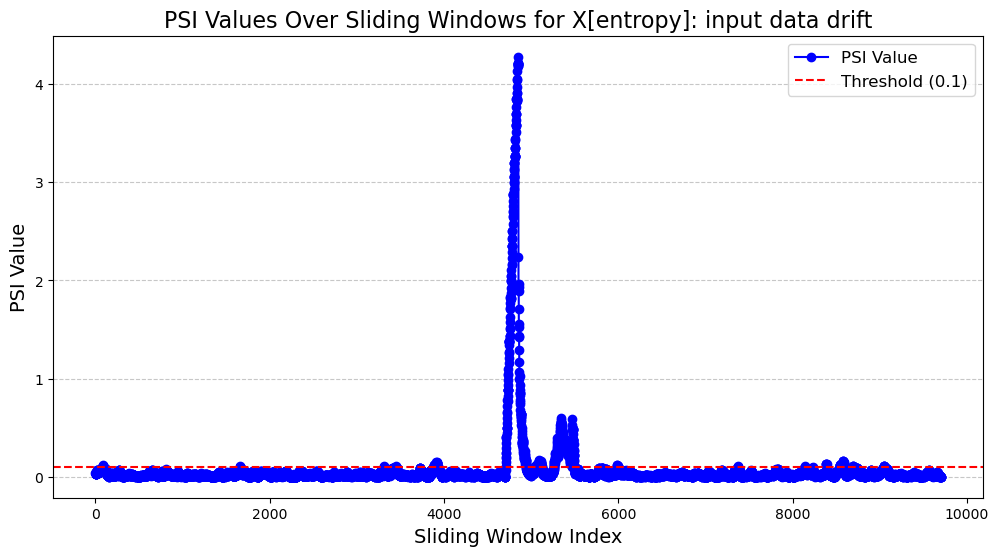

In [193]:
results = df_X['entropy']
psi_values = get_psi_for_simulation_data(results, window_size = 300)
title='PSI Values Over Sliding Windows for X[entropy]: input data drift'
plot_psi(psi_values, title)

# retry

In [194]:
test_df_orig = pd.read_csv("data/rnn-trim/normal_output.csv")
test_df_drift = pd.read_csv("data/rnn-trim/data_drift_output.csv")

In [195]:
test_df_orig.head()

,Unnamed: 0,true_label,y_pred_drifted,entropy,text,entropy_default
0,0,0,0,44.0,s studies were...[trimmed],4.4
1,1,0,0,40.0,previous studi...[trimmed],4.0
2,2,0,0,43.0,""" colorectal ca...[trimmed]",4.3
3,3,0,0,43.0,""" vibrio chole...[trimmed]",4.3
4,4,0,0,44.0,to the human g...[trimmed],4.4


In [196]:
len(test_df_orig)

193

In [197]:
test_df_drift.head()

,Unnamed: 0,true_label,y_pred_drifted,entropy,text,entropy_default
0,0,1,1,46.0,"""materials and ...[trimmed]",4.6
1,1,1,1,45.0,"""Although de To...[trimmed]",4.5
2,2,2,2,46.0,range of diseas...[trimmed],4.6
3,3,1,1,48.0,"""Former (quit ?...[trimmed]",4.8
4,4,2,2,45.0,Rheumatoid art...[trimmed],4.5


In [172]:
len(test_df_drift)

1321

In [198]:
test_df = pd.concat([test_df_orig, test_df_drift], axis=0, ignore_index=True)

In [199]:
test_df.head()

,Unnamed: 0,true_label,y_pred_drifted,entropy,text,entropy_default
0,0,0,0,44.0,s studies were...[trimmed],4.4
1,1,0,0,40.0,previous studi...[trimmed],4.0
2,2,0,0,43.0,""" colorectal ca...[trimmed]",4.3
3,3,0,0,43.0,""" vibrio chole...[trimmed]",4.3
4,4,0,0,44.0,to the human g...[trimmed],4.4


In [200]:
len(test_df)

1514

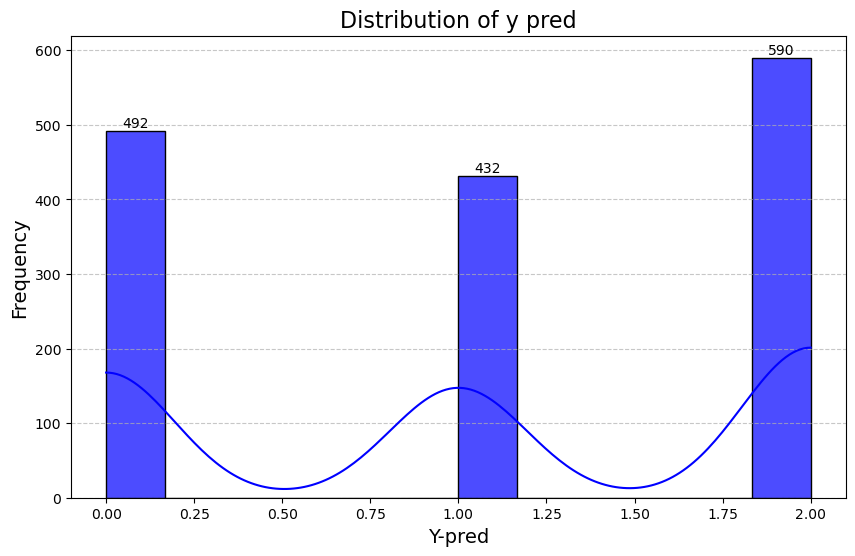

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of y pred
plt.figure(figsize=(10, 6))
ax = sns.histplot(test_df['y_pred_drifted'], kde=True, color='blue', alpha=0.7)

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of y pred', fontsize=16)
plt.xlabel('Y-pred', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

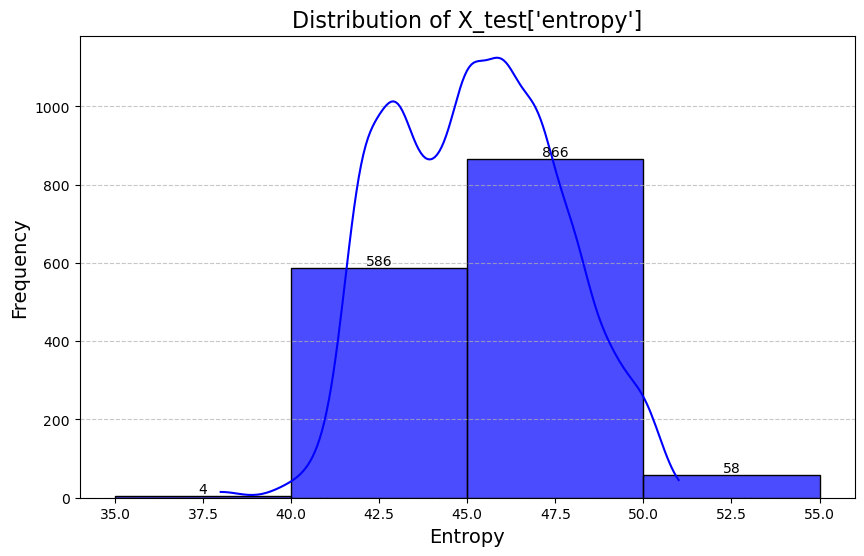

In [203]:
# Plot the distribution of 'entropy'
plt.figure(figsize=(10, 6))
ax = sns.histplot(test_df['entropy'], kde=True, color='blue', alpha=0.7, bins=[35, 40, 45, 50, 55], binrange=(30, 55))

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of X_test[\'entropy\']', fontsize=16)
plt.xlabel('Entropy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [227]:
# First filter by entropy to exclude 45-50 range from filtered samples
eligible_indices = test_df[
    (test_df['entropy'] < 45) | (test_df['entropy'] >= 50)
].index

# Get indices for each class from eligible rows only
class_0_indices = test_df[
    (test_df.index.isin(eligible_indices)) & 
    (test_df['y_pred_drifted'] == 0)
].index
class_1_indices = test_df[
    (test_df.index.isin(eligible_indices)) & 
    (test_df['y_pred_drifted'] == 1)
].index
class_2_indices = test_df[
    (test_df.index.isin(eligible_indices)) & 
    (test_df['y_pred_drifted'] == 2)
].index

# Create filtered_samples (193) with mostly class 0, excluding entropy 45-50
filtered_indices = np.concatenate([
    np.random.choice(class_0_indices, size=450, replace=False),  # Majority class 0
    np.random.choice(class_1_indices, size=54, replace=False),   # Many class 1
    np.random.choice(class_2_indices, size=100, replace=False)    # Few class 2
])
# print({filtered_indices})

# Create filtered samples DataFrame
filtered_samples = test_df.loc[filtered_indices].copy().reset_index(drop=True)

# Get remaining samples as complement
remaining_samples = test_df.loc[~test_df.index.isin(filtered_indices)].copy().reset_index(drop=True)

In [228]:
filtered_samples.head()

,Unnamed: 0,true_label,y_pred_drifted,entropy,text,entropy_default
0,71,0,0,40.0,during the las...[trimmed],4.0
1,112,0,0,44.0,""" lung carcinom...[trimmed]",4.4
2,840,0,0,42.0,nasopharyng...[trimmed],4.2
3,1090,0,0,42.0,among synchrono...[trimmed],4.2
4,379,0,0,42.0,"""ammatory bowe...[trimmed]",4.2


In [229]:
len(filtered_samples)

604

In [230]:
remaining_samples.head()

,Unnamed: 0,true_label,y_pred_drifted,entropy,text,entropy_default
0,44,0,0,42.0,to probiotics ...[trimmed],4.2
1,60,0,0,44.0,gon§ales j...[trimmed],4.4
2,142,0,0,43.0,alcoholic liver...[trimmed],4.3
3,150,1,1,50.0,"""Adenocarcinoma...[trimmed]",5.0
4,151,1,1,50.0,"""peptide vaccin...[trimmed]",5.0


In [231]:
len(remaining_samples)

910

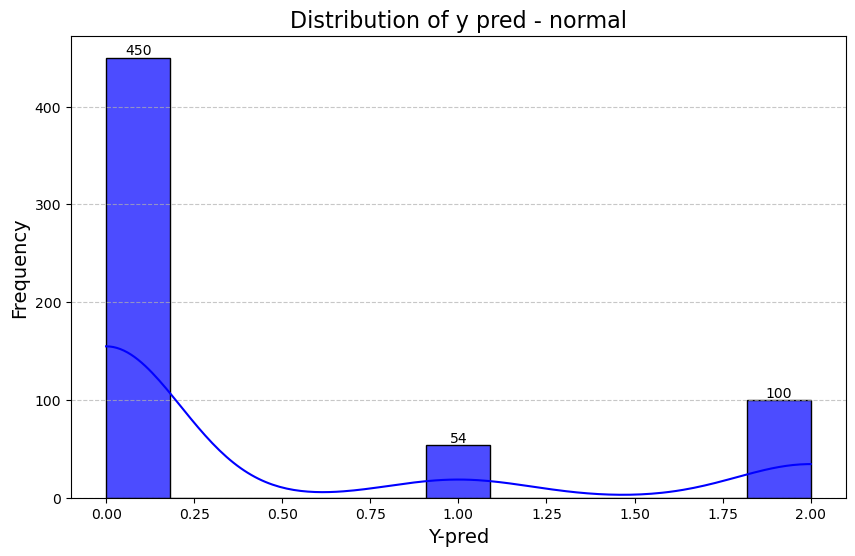

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of y pred
plt.figure(figsize=(10, 6))
ax = sns.histplot(filtered_samples['y_pred_drifted'], kde=True, color='blue', alpha=0.7)

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of y pred - normal', fontsize=16)
plt.xlabel('Y-pred', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

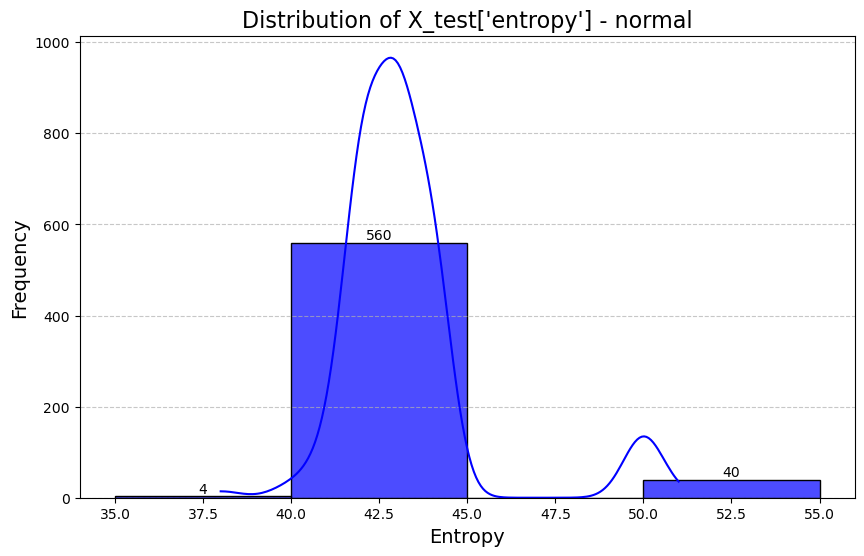

In [241]:
# Plot the distribution of 'entropy'
plt.figure(figsize=(10, 6))
ax = sns.histplot(filtered_samples['entropy'], kde=True, color='blue', alpha=0.7, bins=[35, 40, 45, 50, 55], binrange=(30, 55))

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of X_test[\'entropy\'] - normal', fontsize=16)
plt.xlabel('Entropy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

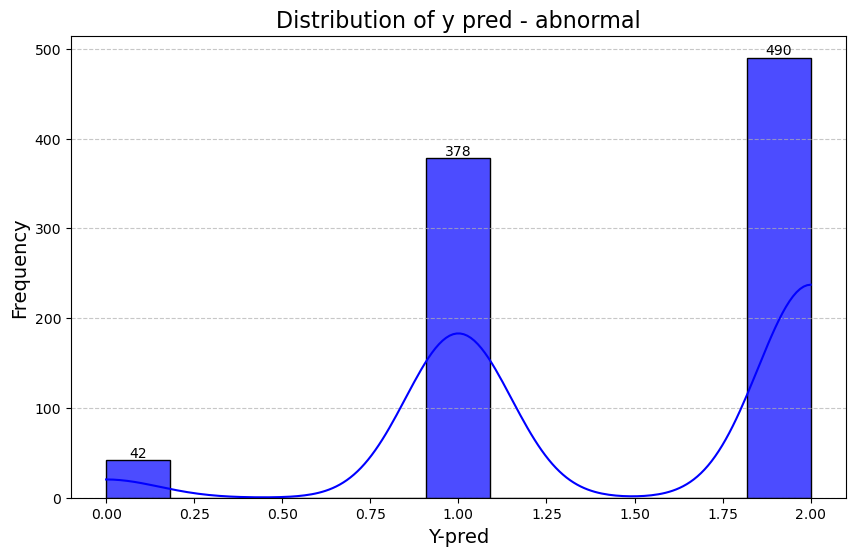

In [242]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of y pred
plt.figure(figsize=(10, 6))
ax = sns.histplot(remaining_samples['y_pred_drifted'], kde=True, color='blue', alpha=0.7)

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of y pred - abnormal', fontsize=16)
plt.xlabel('Y-pred', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

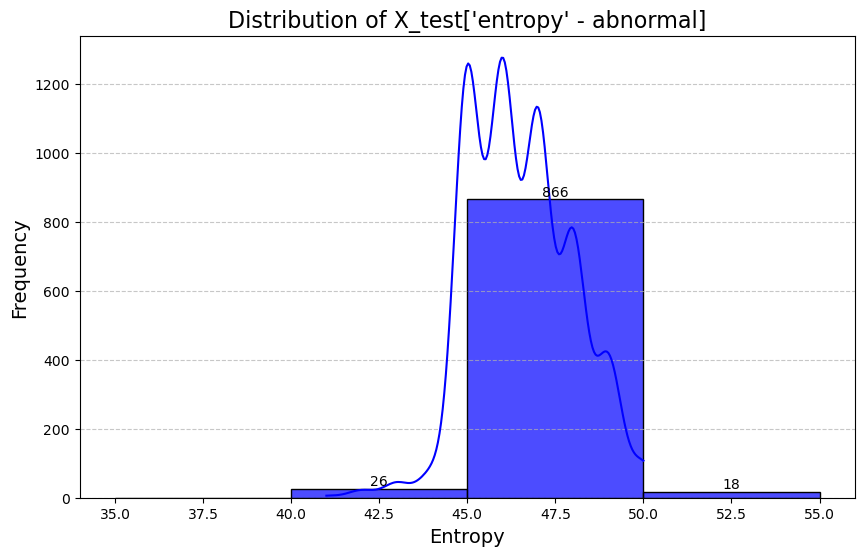

In [243]:
# Plot the distribution of 'entropy'
plt.figure(figsize=(10, 6))
ax = sns.histplot(remaining_samples['entropy'], kde=True, color='blue', alpha=0.7, bins=[35, 40, 45, 50, 55], binrange=(30, 55))

# Annotate each bar with its height
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only annotate bars with a height greater than 0
        ax.annotate(f'{int(height)}', 
                    (patch.get_x() + patch.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of X_test[\'entropy\' - abnormal]', fontsize=16)
plt.xlabel('Entropy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [232]:
calculate_psi(filtered_samples['y_pred_drifted'], remaining_samples['y_pred_drifted'], buckets=3, axis=1)

2.8843993295961856

In [233]:
calculate_psi(filtered_samples['entropy'], remaining_samples['entropy'], buckets=4, axis=1)

9.791623040644616

In [ ]:
def get_psi_for_simulation_data(arr_y, window_size = 300):
    psi_values = []
    results = arr_y
    # Check if results array has enough data
    if len(results) < window_size:
        print("Not enough data in results for sliding window.")
    else:
        # Sliding window loop
        for start in range(len(results) - window_size + 1):
            # Get the current window
            window = results[start:start + window_size]
        
            # Extract expected and actual values
            expected = window[:window_size // 2]  # First half of the window
            actual = window[window_size // 2:]   # Second half of the window
        
            # Debugging: Check sizes
            # print(f"Processing window starting at index {start}")
            # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
            # Calculate PSI for the current window
            psi_value = calculate_psi(expected, actual, buckets=3, axis=0)  # edit
            psi_values.append(psi_value)
    return psi_values

/tmp/ipykernel_253049/3595005488.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_X = pd.concat([df_X, X_sample], ignore_index=True)


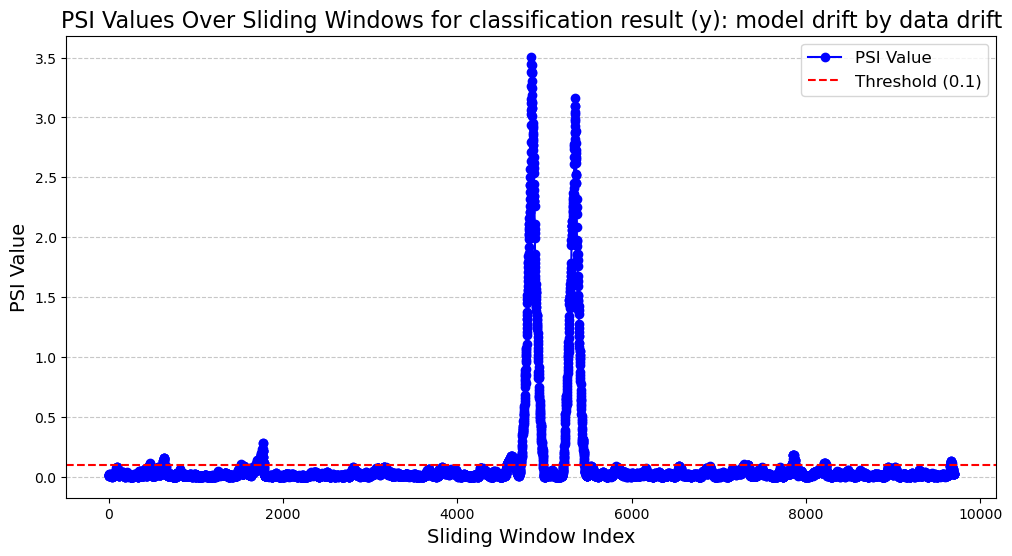

In [234]:
df_X, arr_y =  get_simulation_input(filtered_samples, remaining_samples, filtered_samples['y_pred_drifted'], remaining_samples['y_pred_drifted'], sample_size = 50)
psi_values = get_psi_for_simulation_data(arr_y, window_size = 300)
title='PSI Values Over Sliding Windows for classification result (y): model drift by data drift'
plot_psi(psi_values, title)

In [235]:
def get_psi_for_simulation_data(arr_y, window_size = 300):
    psi_values = []
    results = arr_y
    # Check if results array has enough data
    if len(results) < window_size:
        print("Not enough data in results for sliding window.")
    else:
        # Sliding window loop
        for start in range(len(results) - window_size + 1):
            # Get the current window
            window = results[start:start + window_size]
        
            # Extract expected and actual values
            expected = window[:window_size // 2]  # First half of the window
            actual = window[window_size // 2:]   # Second half of the window
        
            # Debugging: Check sizes
            # print(f"Processing window starting at index {start}")
            # print(f"Expected size: {len(expected)}, Actual size: {len(actual)}")
        
            # Calculate PSI for the current window
            psi_value = calculate_psi(expected, actual, buckets=4, axis=0)  # edit
            psi_values.append(psi_value)
    return psi_values

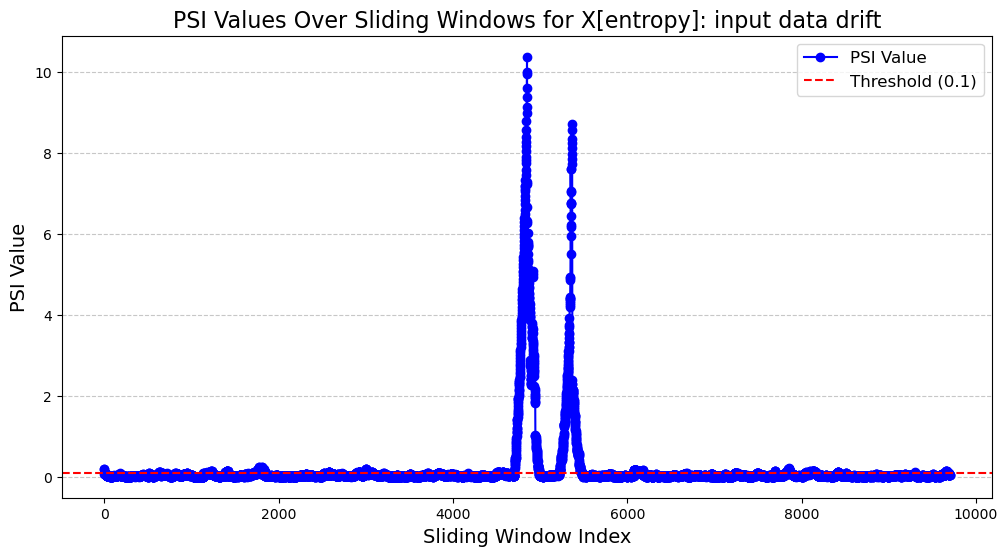

In [236]:
results = df_X['entropy']
psi_values = get_psi_for_simulation_data(results, window_size = 300)
title='PSI Values Over Sliding Windows for X[entropy]: input data drift'
plot_psi(psi_values, title)

In [237]:
test_results = filtered_samples.copy()
test_results.head()
test_results.to_csv("data/rnn-redo/normal_output.csv")

In [238]:
test_results = remaining_samples.copy()
test_results.head()
test_results.to_csv("data/rnn-redo/data_drift_output.csv")

In [239]:
print(filtered_indices)

[  71  112 1033 1283  572 1338  620   16   27 1199  540   50   43  706
    9  833  796 1256  778    1   23  800 1479  268  378  576  455  439
  413  113  900 1250  875  584   39 1392  591   81   64  868  231 1122
   92   56 1040  686   93 1168  472  125   58  136  838 1489   82  460
 1042  121   78 1188   19  289  559  130  653  433   12  840   90  119
  961  236  811 1229  966 1100  602  538  398   37  243   34 1491 1435
  656   13  793 1080  615  394  218 1074   17 1476  945   63 1215   76
 1494   83 1444  126  774  406 1205  292   69  426  816  975 1203 1049
  427  597  202   20   67  827  849   94  304  759  792    2 1211  566
  836 1046 1136 1268 1154   75  873  222  129  115  603 1219 1266  131
  640 1246   89  751  128  111   53  356 1179  103 1204  995 1309 1353
 1083   96    3  300  206 1173  881  144 1381 1449  105 1312 1416  874
  725  556 1224  594   97  374  454   49  459    7 1292 1498  560  134
 1051 1480   52 1339  375    8  658  667 1484  250  143  732 1165  255
  395 